Create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/ec2-user/geoseg/segment-anything/notebooks


## Load Model

In [2]:
import torch

DEVICE = torch.device('cuda')
MODEL_TYPE = "vit_b"

In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_m0twmjw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_m0twmjw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '../weights/sam_vit_b_01ec64.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)

predictor = SamPredictor(sam)

In [6]:
import cv2
from PIL import Image

img = cv2.imread('../imgs/clasts.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
predictor.set_image(img)

In [8]:
import json
import torch

# place an image "img.png" and a json file "img.json" in the cd

# Read the JSON file
with open('../imgs/000.json', 'r') as file:
    data = json.load(file)
    bboxes = data['bboxes']

# 20 boxes per bin
input_boxes_batches = []
curr_batch = []
count = 0
for bbox in bboxes:
    x, y, w, h = bbox
    count += 1
    if (count != 20):
        curr_batch.append([x, y, x+w, y+h])
    else:
        input_boxes_batches.append(curr_batch)
        curr_batch = []
        curr_batch.append([x, y, x+w, y+h])
        count = 1

In [9]:
import torch
import gc

In [10]:
masks_batches = []

for input_boxes in input_boxes_batches:
    tens_boxes = torch.tensor(input_boxes, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(tens_boxes, img.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    masks_batches.append(masks)

    # Delete the tensors
    del tens_boxes
    # If you have other tensors or models on GPU, you should delete them as well

    # Empty the cache
    torch.cuda.empty_cache()

    # Run the garbage collector
    gc.collect()


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [12]:
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# for masks in masks_batches:
#     for mask in masks:
#         show_mask(mask.cpu().numpy(), plt.gca(), random_color=False)
# plt.axis('off')
# plt.show()
# print(len(masks_batches))

In [13]:
result = []
for masks in masks_batches:
    for mask in masks:
        result.append(mask.cpu().numpy())
        

# print(len(result))
print(result[0])

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


In [14]:
import numpy as np
import cv2

polygons = []

for j, res in enumerate(result):
    # Convert the boolean mask to a format suitable for OpenCV
    res = result[j]

    # Ensure the mask is a 2D array
    if res.ndim > 2:
        res = res.squeeze()  # Remove singleton dimensions

    # Check if the result is non-empty and 2D
    if res.ndim == 2 and res.size > 0:
        # Convert the boolean mask to a format suitable for OpenCV
        mask = (res.astype(np.uint8) * 255)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        polygons += [cv2.approxPolyDP(contour, 1, True).tolist() for contour in contours]
    else:
        print("Invalid mask shape or empty mask")


[[1408, 846]]
[[1258, 836]]
[[675, 517]]
[[958, 813]]
[[1146, 733]]
[[1124, 1129]]
[[1079, 497]]
[[696, 962]]
[[717, 595]]
[[1483, 974]]
[[1566, 995]]
[[1542, 703]]
[[1034, 1149]]
[[1169, 561]]
[[944, 1173]]
[[917, 888]]
[[769, 966]]
[[726, 831]]
[[715, 866]]
[[1229, 1071]]
[[1333, 961]]
[[1141, 1033]]
[[800, 863]]
[[1332, 724]]
[[1483, 1155]]
[[777, 667]]
[[1592, 480]]
[[1457, 523]]
[[1554, 1115]]
[[1112, 1067]]
[[1465, 493]]
[[834, 1132]]
[[848, 1089]]
[[726, 815]]
[[847, 972]]
[[945, 962]]
[[982, 564]]
[[1476, 771]]
[[1417, 725]]
[[1293, 523]]
[[1483, 657]]
[[713, 568]]
[[1290, 612]]
[[1185, 652]]
[[1546, 606]]
[[907, 1009]]
[[1457, 1044]]
[[1497, 720]]
[[769, 930]]
[[1537, 1180]]
[[903, 1070]]
[[798, 803]]
[[1308, 1117]]
[[711, 448]]
[[1039, 917]]
[[848, 755]]
[[1581, 773]]
[[1151, 975]]
[[1044, 614]]
[[1606, 456]]
[[954, 962]]
[[1348, 554]]
[[1365, 554]]
[[1422, 967]]
[[918, 874]]
[[1419, 1109]]
[[1607, 870]]
[[793, 545]]
[[843, 617]]
[[1245, 671]]
[[1294, 825]]
[[1038, 975]]
[[96

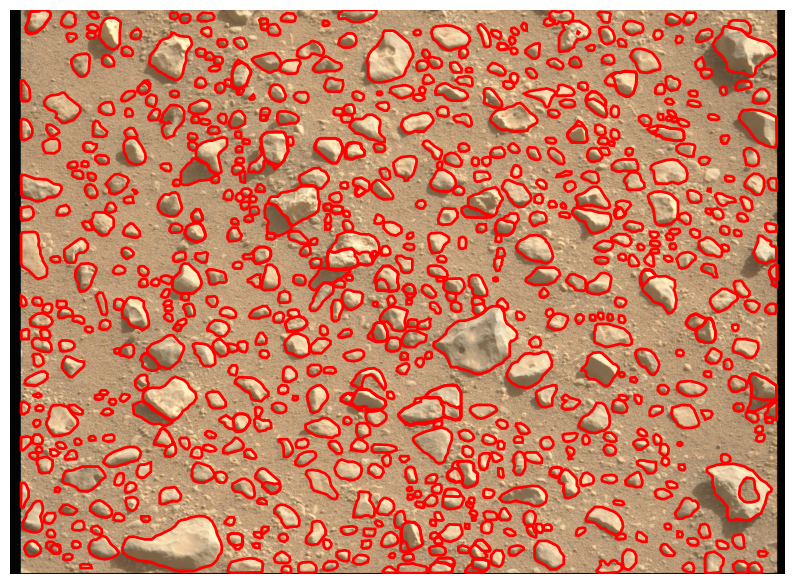

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

# Add the polygons to the plot
for poly in polygons:
    print(poly[0])
    # Remove the extra level of nesting in the polygon points
    poly_np = np.array(poly).reshape(-1, 2)
    polygon_patch = Polygon(poly_np, edgecolor='red', fill=False, linewidth=2)
    ax.add_patch(polygon_patch)

# Remove axis ticks and labels
ax.axis('off')

# Show the plot
plt.show()


In [16]:
def polygon_area(polygon):
    """Calculate the area of a polygon using the shoelace formula."""
    n = len(polygon)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += polygon[i][0][0] * polygon[j][0][1]
        area -= polygon[j][0][0] * polygon[i][0][1]
    area = abs(area) / 2.0
    return area

# Example usage
polygon = [[[1408, 846]], [[1406, 858]], [[1409, 868]], [[1423, 885]], [[1433, 889]], [[1446, 889]], [[1457, 887]], [[1463, 884]], [[1465, 877]], [[1454, 850]], [[1445, 841]], [[1428, 840]]]
print("Polygon area:", polygon_area(polygon))

Polygon area: 2168.5


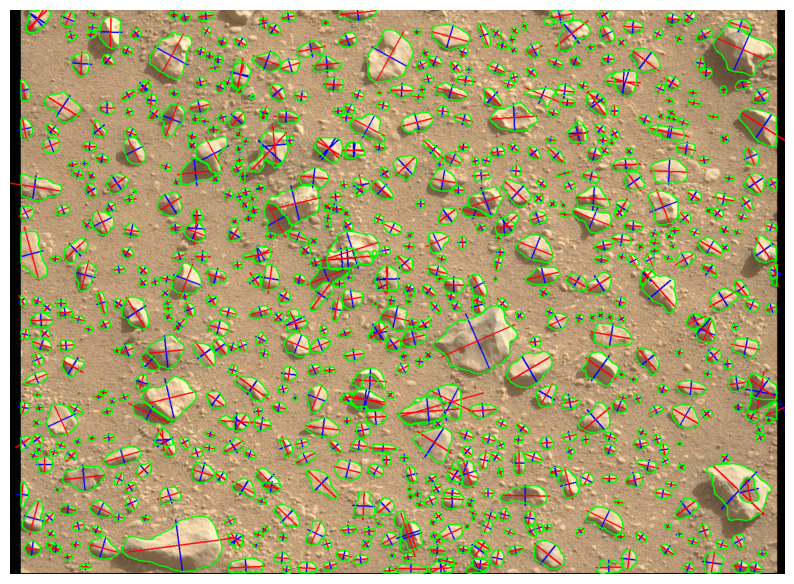

Angles: [120.14354705810547, 49.13130569458008, 72.43875122070312, 74.57551574707031, 59.60792922973633, 128.31866455078125, 111.69378662109375, 103.49646759033203, 80.80669403076172, 133.3857879638672, 168.04537963867188, 100.78148651123047, 11.815177917480469, 76.91378784179688, 62.46178436279297, 122.81076049804688, 118.93679809570312, 105.54035949707031, 88.64962005615234, 115.79398345947266, 103.11863708496094, 90.98196411132812, 87.76002502441406, 140.47134399414062, 8.749512672424316, 175.5368194580078, 144.53041076660156, 61.1405029296875, 152.9701385498047, 9.975557327270508, 119.61612701416016, 162.49554443359375, 57.2556037902832, 166.03143310546875, 109.75285339355469, 151.72988891601562, 101.51287841796875, 107.19303894042969, 104.230712890625, 23.176271438598633, 99.88349914550781, 102.16358947753906, 63.320953369140625, 59.105072021484375, 58.6398811340332, 52.01996612548828, 47.57923889160156, 91.83869934082031, 98.8984146118164, 139.06637573242188, 93.14420318603516, 8

In [67]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.figure(figsize=(10, 10))

# Convert image to RGB for matplotlib display
img_rgb = img
plt.imshow(img_rgb)
plt.axis('off')

long_axes = []
short_axes = []
counted_areas = []
angles = []

# Loop through the segments to draw additional details
for polygon in polygons:
    
    # Ensure the polygon has at least 5 points
    if len(polygon) >= 5:
        # Fit an ellipse to the polygon and get its parameters
        poly_pts = np.array(polygon, np.int32).reshape((-1, 1, 2))
        ellipse = cv2.fitEllipse(poly_pts)
        (center_x, center_y), (major_axis, minor_axis), angle = ellipse
        angles.append(angle)
        
        # Calculate the endpoints of the long and short axes
        angle_rad = np.radians(angle)
        cos_angle = np.cos(angle_rad)
        sin_angle = np.sin(angle_rad)
        
        half_major_axis = major_axis / 2
        half_minor_axis = minor_axis / 2
        short_axes.append(half_major_axis)
        long_axes.append(half_minor_axis)
        counted_areas.append(polygon_area(polygon))
        
        start_long = (int(center_x - cos_angle * half_major_axis), int(center_y - sin_angle * half_major_axis))
        end_long = (int(center_x + cos_angle * half_major_axis), int(center_y + sin_angle * half_major_axis))
        
        start_short = (int(center_x + sin_angle * half_minor_axis), int(center_y - cos_angle * half_minor_axis))
        end_short = (int(center_x - sin_angle * half_minor_axis), int(center_y + cos_angle * half_minor_axis))
        
        # Draw the axes on the image with a smaller line width
        cv2.line(img_rgb, start_long, end_long, (0, 0, 255), 2)  # Red for long axis
        cv2.line(img_rgb, start_short, end_short, (255, 0, 9), 2)  # Blue for short axis
        
        pts = np.array(polygon, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(img_rgb, [pts], True, (0, 255, 0), 2)  # Smaller line width for the border

# Redisplay the image with the additional annotations
plt.imshow(img_rgb)
plt.show()

# Print the angles
print("Angles:", angles)


## Convert from pixels to mm ##
Using line (vertical) FOV & focal distance from PDS XML file

In [77]:
import math

# FOV angle in degrees for the height
line_fov_deg = 4.63392

# Distance to the floor in mm
distance_to_floor = 2100.0

# Image height in pixels
image_height_pix = 1200

# Converting the FOV angle from degrees to radians
line_fov_rad = math.radians(line_fov_deg)

# Calculating the real-world height of the image
real_world_height = 2 * math.tan(line_fov_rad / 2) * distance_to_floor

# Calculating the height of one pixel
height_per_pixel = real_world_height / image_height_pix

# Printing the result
print(f"Height per pixel: {height_per_pixel:.6f} mm")

Height per pixel: 0.141612 mm


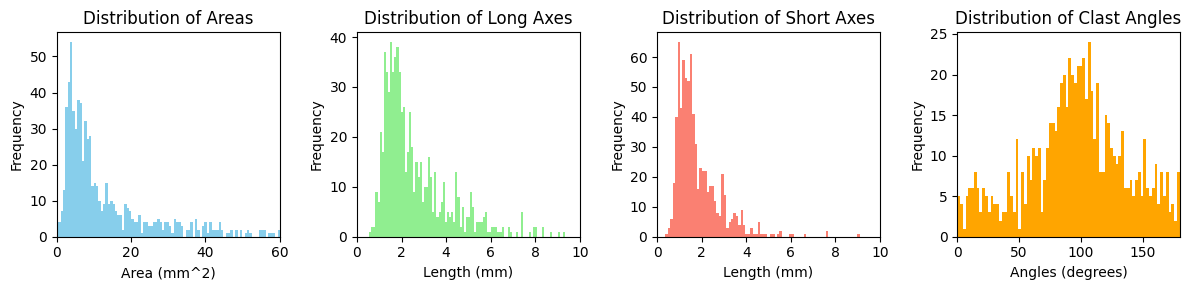

In [82]:
# Assuming you have collected 'areas', 'long_axes', and 'short_axes' data for all segments across images
# For demonstration, let's create some sample data

import numpy as np
import matplotlib.pyplot as plt

# Plotting the distribution of areas
real_areas = [np.round(area * (height_per_pixel ** 2), 4) for area in counted_areas]
real_longs = [long_axis * height_per_pixel for long_axis in long_axes]
real_shorts = [short_axis * height_per_pixel for short_axis in short_axes]

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.hist(real_areas, bins=500, color='skyblue')
plt.title('Distribution of Areas')
plt.xlabel('Area (mm^2)')
plt.ylabel('Frequency')
plt.xlim(0, 60)

# Plotting the distribution of long axes
plt.subplot(1, 4, 2)
plt.hist(real_longs, bins=160, color='lightgreen')
plt.title('Distribution of Long Axes')
plt.xlabel('Length (mm)')
plt.ylabel('Frequency')
plt.xlim(0, 10)

# Plotting the distribution of short axes
plt.subplot(1, 4, 3)
plt.hist(real_shorts, bins=80, color='salmon')
plt.title('Distribution of Short Axes')
plt.xlabel('Length (mm)')
plt.ylabel('Frequency')
plt.xlim(0, 10)

# Plotting the distribution of short axes
plt.subplot(1, 4, 4)
plt.hist(angles, bins=80, color='orange')
plt.title('Distribution of Clast Angles')
plt.xlabel('Angles (degrees)')
plt.ylabel('Frequency')
plt.xlim(0, 180)

plt.tight_layout()
plt.show()


In [83]:
import pandas as pd

# Create a DataFrame from the series
data = pd.DataFrame({'Areas': real_areas, 'Long Axes': real_longs, 'Short Axes': real_shorts, 'Angles': angles})

# Print summary statistics for all three
print(data.describe())


            Areas   Long Axes  Short Axes      Angles
count  739.000000  739.000000  739.000000  739.000000
mean    17.284085    2.670964    1.827688   95.693372
std     26.550506    1.697178    1.024233   40.945800
min      0.371000    0.545321    0.373805    0.024781
25%      4.667600    1.546677    1.150949   73.060246
50%      8.422700    2.068744    1.502764   97.375130
75%     19.327050    3.275813    2.216631  122.144310
max    317.886400   15.642661    9.086372  179.703903
